In [51]:
#!pip install pint
#!pip install scikit-image
#!pip install opencv-python
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
from skimage import data
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pint
from scipy.signal import argrelextrema

control = Image.open('control.png')
singleslit = Image.open('singleslit.png')
diffraction_grating = Image.open('diffraction_grating.png')
pinhole = Image.open('pinhole.png')
crop_grating = Image.open('crop_grating.png')

u = pint.UnitRegistry()
%matplotlib inline

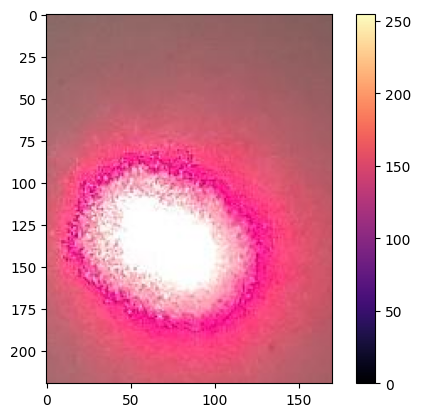

In [52]:
top = 650
bottom = 870
left = 850
right = 1020

crop_control = control.crop((left,top,right,bottom))
cmap = plt.cm.magma
plt.imshow(crop_control, cmap=cmap)
plt.colorbar()

In [56]:
class calculate_diffraction:
    '''
    Calculates diffraction
    '''
    def __init__(self,diffraction,variety,image,top,bottom,left,right):
        '''
        Initial variables to create the object
        '''
        self.diffraction = diffraction # Specifies type geometry of diffraction
        self.image = image # Pulls the experimental image
        self.top = top # Top, Bottom, Left and Right are the crop dimensions
        self.bottom = bottom
        self.left = left
        self.right = right
        self.variety = variety # 
        
    def image_processing(self):
        '''
        Takes the cropped image and scales it to a 1 cm line included in each image.
        Then uses that scale to create x-ticks for our simulated graphs later.
        Function must be called whenever you want to compare a simulation to experimental image.
        '''
        string1 = 'crop_'
        string2 = '.png'
        path = string1 + self.diffraction + string2
        self.path = path
        crop = plt.imread(self.path)
        self.crop = crop
        height, w, _ = crop.shape
        self.height = height
        self.w = w
        width = right_scale-left_scale
        self.width = width
        scale_length = self.width
        self.scale_length = scale_length
        pixels_per_cm = self.scale_length
        self.pixels_per_cm = pixels_per_cm
        x_ticks = np.arange(0, self.w, self.pixels_per_cm)
        self.x_ticks = x_ticks
        
    def set_scale(self,top_scale,bottom_scale,left_scale,right_scale):
        '''
        Instantiates the scale factor from the experimental image.
        '''
        self.top_scale = top_scale
        self.bottom_scale = bottom_scale
        self.left_scale = left_scale
        self.right_scale = right_scale
        
    def set_R(self,R):
        '''
        If a pinhole aperture is being used, it is necessary to set_R for the radius of the pinhole.
        '''
        self.R = R
        
    def get_R(self):
        '''
        This function will pull the instantiated radius of a pinhole.
        '''
        return self.R
    
    def set_D(self,D):
        '''
        This function sets the width of the slit(s).
        '''
        self.D = D
        
    def get_D(self):
        '''
        This function retrieves the instantiated width of the slit(s).
        '''
        return self.D
    
    def set_lam(self,lam):
        '''
        This function sets the value for lambda, the wavelength of light.
        '''
        self.lam = lam
        k = 2*np.pi / (self.lam)
        self.k = k
        
    def get_lam(self):
        '''
        This function retrieves the instantiated value for lambda, the wavelength of light.
        '''
        return self.lam
    
    def get_k(self):
        '''
        This function retrieves the instantiated momentum magnitude of the light.
        '''
        self.k = k
        
    def set_z(self,z):
        '''
        This function sets the distance between the apeture and the screen.
        '''
        self.z = z
        
    def get_z(self):
        '''
        This function retrieves the instantiated distance between the aperture and the screen.
        '''
        return self.z
    
    def set_h(self,h):
        '''
        This function sets the height of the slit(s).
        '''
        self.h = h
        
    def get_h(self):
        '''
        This function retrieves the instantiated value of the height of the slit(s).
        '''
        return self.h
    
    def set_slits(self,horizontal,vertical):
        '''
        This function allows the user to specify how many slits to place in a grid - horizontal by vertical
        '''
        self.horizontal = horizontal
        self.vertical = vertical
    
    def set_S(self,S):
        '''
        This function sets the spacing between the slits.
        '''
        self.S = S
        
    '''
    If one or more slits are being simulated, the geometry (U0), will be calculated differently
    depending on whether horizontal or vertical is even or odd and vice-versa.
    '''
        
    def even_even(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(1,num_horiz,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(1,num_vert,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(1,num_horiz,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(1,num_vert,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
        
    def odd_odd(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(0,num_horiz+1,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(0,num_vert+1,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(0,num_horiz+1,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(0,num_vert+1,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
    
    def even_odd(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(1,num_horiz,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(0,num_vert+1,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(1,num_horiz,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(0,num_vert+1,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
        
    def odd_even(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(0,num_horiz+1,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(1,num_vert,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(0,num_horiz+1,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(1,num_vert,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
    
    def set_x(self,x):
        '''
        This function sets the size of the mesh grid used to simulate the apertures.
        As it currently stands, the combined size and spacings of the slits can not be
        greater than the length chosen for x.
        
        The function then checks parity of the number of horizontal vs vertical slits
        and calls the appropriate function to calculate the geometry.
        '''
        self.x = x
        xv,yv = np.meshgrid(self.x,self.x)
        self.xv = xv
        self.yv = yv
        if self.variety == 'pinhole':
            U0 = xv**2 + yv**2 < self.R**2
            U0 = U0.astype(float)
            self.U0 = U0
        elif self.variety == 'slits':
            
            if self.horizontal % 2 == 0 and self.vertical %2 == 0:
                U0 = self.even_even(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 != 0 and self.vertical %2 != 0:
                U0 = self.odd_odd(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 == 0 and self.vertical %2 != 0:
                U0 = self.even_odd(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 != 0 and self.vertical %2 == 0:
                U0 = self.odd_even(self.horizontal,self.vertical)
                self.U0 = U0

    def get_U0(self):
        '''
        This function retrieves the instantiated aperture geometry.  This will return a matrix.
        '''
        return self.U0
    
    def get_mesh(self):
        '''
        This function retrieves the instantiated dimensions of the simulation mesh, on which
        the aperature(s) are placed.
        '''
        return self.xv,self.yv
    
    def get_x(self):
        '''
        This function retrieves the instantiated length of the simulation mesh.
        '''
        return self.x
    
    def compute_U(self):
        '''
        Regardless of geometry chosen, this function takes the inverse 2-dimensional
        Fast Fourier Transform (FFT) of the geometry to calculate the diffraction pattern.
        '''
        A = fft2(self.U0)
        self.A = A
        self.kx = 2*np.pi * fftfreq(len(self.x), np.diff(self.x)[0])
        self.kxv, self.kyv = np.meshgrid(self.kx,self.kx)
        self.k = 2*np.pi/self.lam
        U = ifft2(self.A*np.exp(1j*self.z*np.sqrt(self.k**2-self.kxv**2-self.kyv**2)))
        self.U = U
        
    def sim_aperture(self):
        '''
        This function returns a plot of the mesh and apperatures placed thereon.
        '''
        plt.figure(figsize=(5,5))
        plt.pcolormesh(self.xv,self.yv,self.U0)
        plt.xlabel('X-Position [mm]')
        plt.ylabel('Y-Position [mm]')
        return plt.show()

    def plot(self):
        '''
        This function returns the plot of the diffraction pattern on the left
        and the plot of the scaled diffraction pattern of the experimental image on the right.
        '''
        rows = 1
        columns = 2
        fig, (ax1, ax2) = plt.subplots(rows,columns,figsize = (10,5))
        ax1.pcolormesh(self.xv,self.yv,np.abs(self.U), cmap='inferno')
        ax1.set(title='Simulated Diffraction Pattern', ylabel='$y$ [cm]', xlabel='$x [cm]$')
        ax2.imshow(self.image)
        ax2.set(title='Experimental Diffraction Pattern', ylabel='$y$ [cm]', xlabel='$x [cm]$')
        ax2.set_xticks(self.x_ticks)
        ax2.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        return plt.show()
        
    def plot_exp_image(self):
        '''
        This function plots the experimental image.
        '''
        
        fig, ax = plt.subplots()
        ax.imshow(self.crop)
        ax.set_xticks(self.x_ticks)
        ax.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        plt.show()
        
        return plt.show()
    
    def get_extrema_sim(self):
        '''
        This function returns a plot of a 'slice' of the simulated diffraction pattern.  (Intensity vs. Position)
        '''

        y = np.abs(self.U)[250]
        maxima_idx = argrelextrema(y, np.greater)[0]
        minima_idx = argrelextrema(y, np.less)[0]
        fig, ax = plt.subplots()
        plt.plot(self.x, y)
        plt.plot(self.x[maxima_idx], y[maxima_idx], 'ro')
        plt.plot(self.x[minima_idx], y[minima_idx], 'bo')
        return plt.show()
    
    def get_extrema_exp(self):
        '''
        This function calculates the extrema of the experimental image.
        '''

        img = Image.open(self.path).convert('L')
        img_arr = np.asarray(img)
        max_col = np.argmax(np.sum(img_arr, axis=0))
        intensity_values = img_arr[:, max_col]
        maxima_idx = argrelextrema(intensity_values, np.greater)[0]
        minima_idx = argrelextrema(intensity_values, np.less)[0]
        fig, ax = plt.subplots()
        ax.plot(intensity_values)
        ax.plot(maxima_idx, intensity_values[maxima_idx], 'ro')
        ax.plot(minima_idx, intensity_values[minima_idx], 'bo')
        ax.set_xlabel('Position')
        ax.set_ylabel('Intensity')
        x_ticks = np.arange(0, img_arr.shape[0], self.pixels_per_cm)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f"{i // (self.pixels_per_cm/10)} mm" for i in x_ticks], rotation=45)
        ax.set_title('Intensity vs Position')
        plt.show()

In [ ]:
# Diffraction Grating

top_scale = 550
bottom_scale = 640
left_scale = 767
right_scale = 798

top = 700
bottom = 870
left = 950
right = 1150

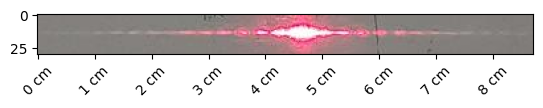

In [64]:
top = 840
bottom = 870
left = 800
right = 1175

top_scale = 400
bottom_scale = 600
left_scale = 747
right_scale = 790

crop_single = singleslit.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_single.png'
#crop_single.save(path)

single_slit = calculate_diffraction('single','slits',crop_single,top,bottom,left,right)
single_slit.set_scale(top_scale,bottom_scale,left_scale,right_scale)
single_slit.set_slits(1,1)
single_slit.set_S(3*u.mm)
single_slit.image_processing()
single_slit.set_h(1*u.mm)
single_slit.set_R('None')
single_slit.set_lam(660 * u.nm)
single_slit.set_D(2 * u.mm)
single_slit.set_x(np.linspace(-5,5,1600) * u.cm)
single_slit.set_z(700*u.cm)
single_slit.compute_U()
single_slit.plot_exp_image()

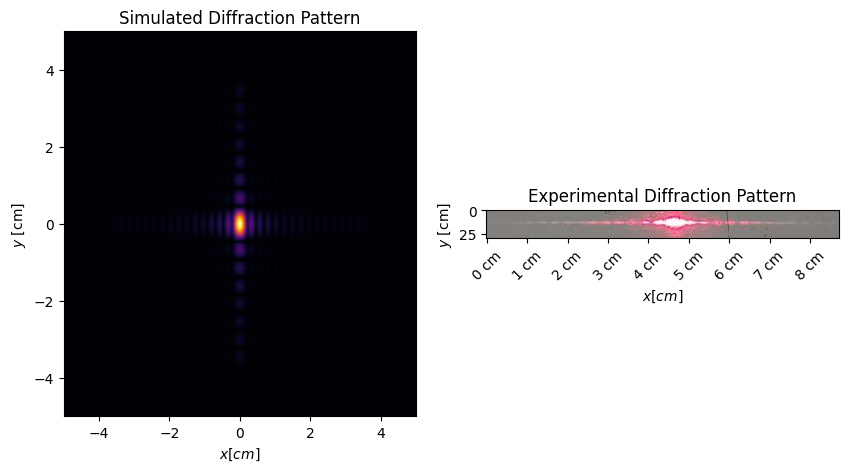

In [65]:
single_slit.plot()

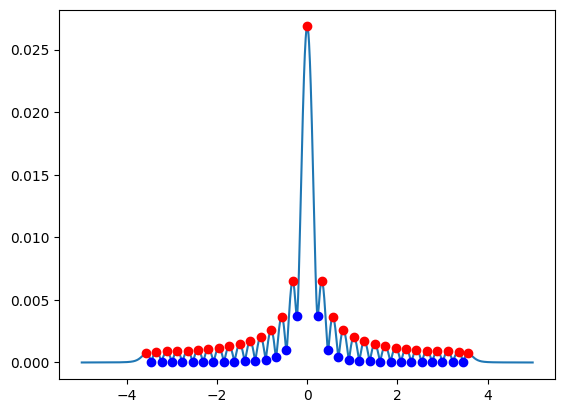

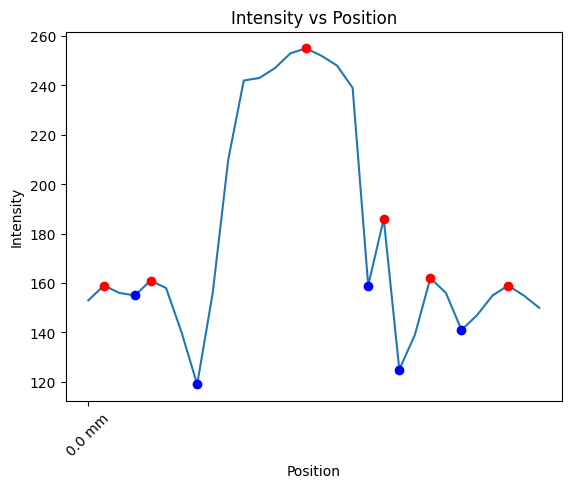

In [66]:
single_slit.get_extrema_sim()
single_slit.get_extrema_exp()

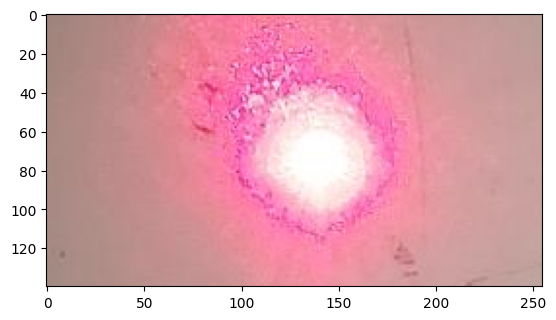

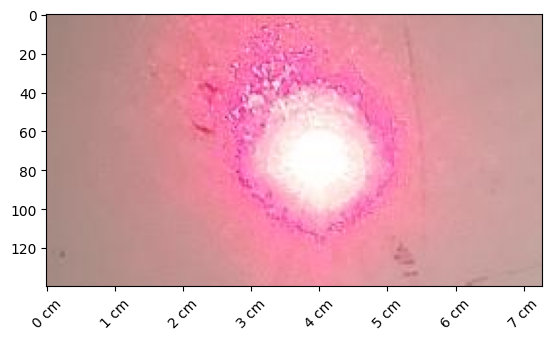

In [81]:
top = 710
bottom = 850
left = 845
right = 1100

top_scale = 400
bottom_scale = 500
left_scale = 772
right_scale = 807

crop_pinhole = pinhole.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_pinhole.png'

#crop_pinhole.save(path)





pinhole_diffraction = calculate_diffraction('pinhole','pinhole',crop_pinhole,top,bottom,left,right)
pinhole_diffraction.set_scale(top_scale,bottom_scale,left_scale,right_scale)
pinhole_diffraction.image_processing()
pinhole_diffraction.set_R(0.8*u.mm)
pinhole_diffraction.set_h('None')
pinhole_diffraction.set_lam(600 * u.nm)
pinhole_diffraction.set_D(0.8 * u.mm)
pinhole_diffraction.get_R()
pinhole_diffraction.set_x(np.linspace(-1.5,1.5,1600) * u.cm)
pinhole_diffraction.set_z(700*u.cm)
pinhole_diffraction.compute_U()
pinhole_diffraction.plot_exp_image()

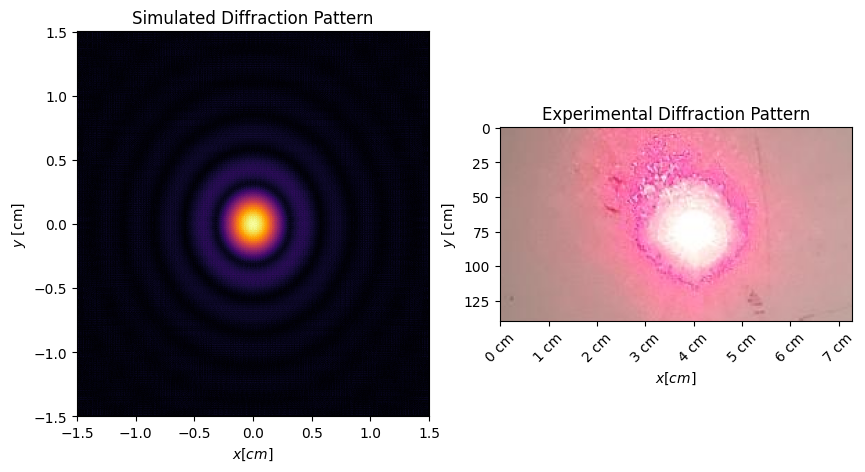

In [82]:
pinhole_diffraction.plot()

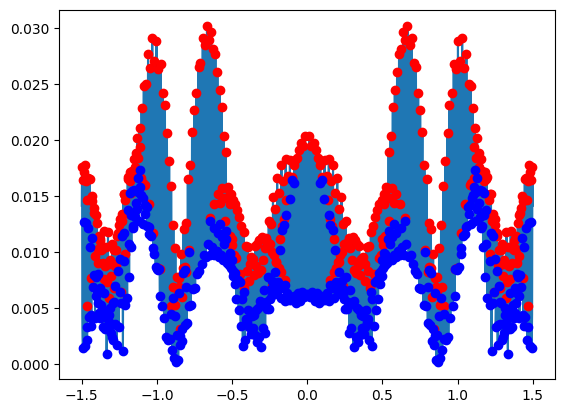

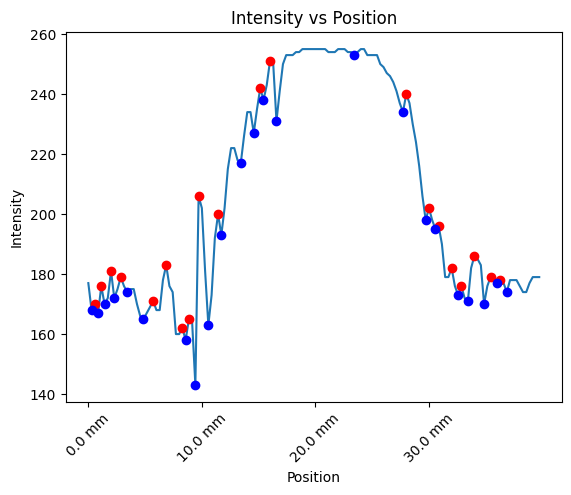

In [83]:
pinhole_diffraction.get_extrema_sim()
pinhole_diffraction.get_extrema_exp()

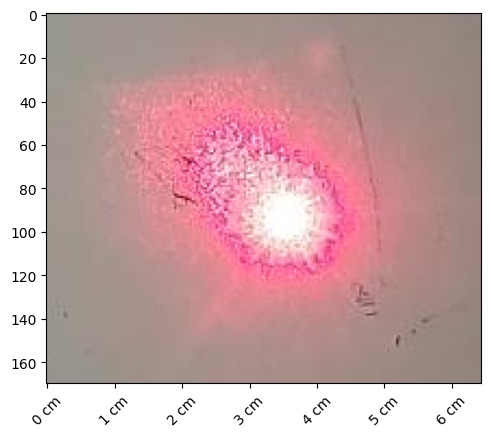

In [84]:
top = 700
bottom = 870
left = 950
right = 1150

top_scale = 550
bottom_scale = 640
left_scale = 767
right_scale = 798

grating = diffraction_grating.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_grating.png'
#grating.save(path)

grating = calculate_diffraction('grating','slits',crop_grating,top,bottom,left,right)
grating.set_slits(20,20)
grating.set_S(3*u.mm)
grating.set_scale(top_scale,bottom_scale,left_scale,right_scale)
grating.image_processing()
grating.set_R('None')
grating.set_h(1*u.mm)
grating.set_lam(600 * u.nm)
grating.set_D(0.8 * u.mm)
grating.get_R()
grating.set_x(np.linspace(-1.5,1.5,1600) * u.cm)
grating.set_z(700*u.cm)
grating.compute_U()
grating.plot_exp_image()

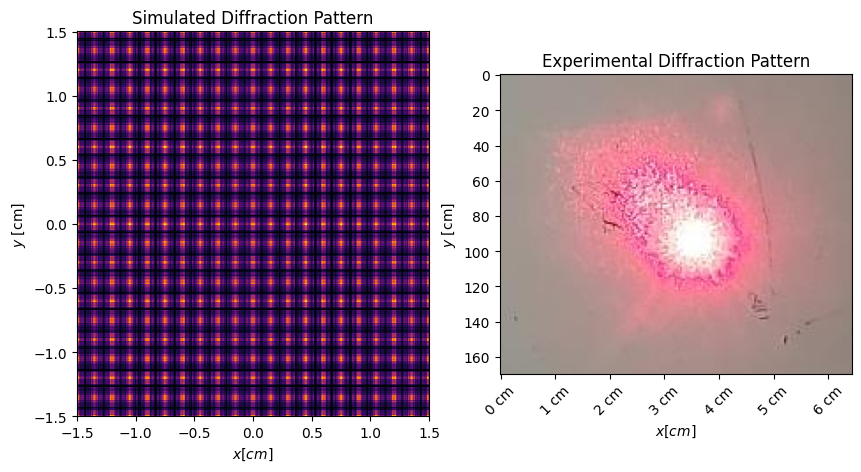

In [85]:
grating.plot()

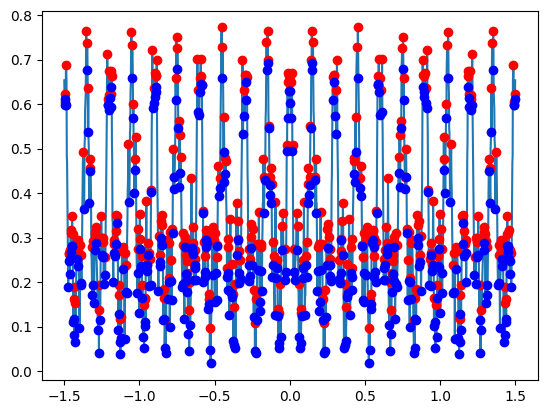

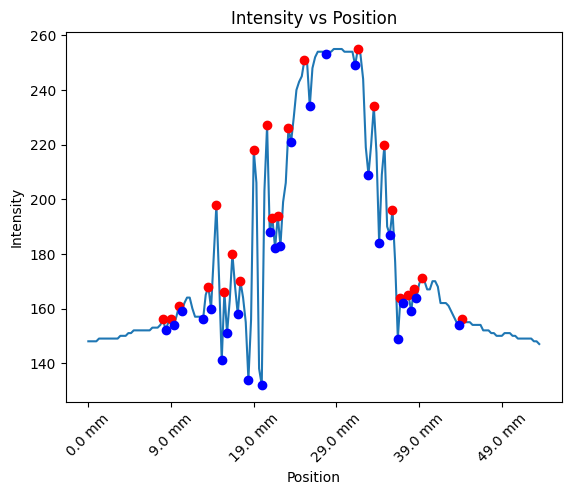

In [86]:
grating.get_extrema_sim()
grating.get_extrema_exp()